regular bayes between 20-2000

In [2]:
# General
import numpy as np
import pandas as pd
import os, sys
import optuna

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from sklearn.preprocessing import StandardScaler

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt
import matplotlib as mpl    
mpl.rcParams["text.usetex"] = False


# Portfolio allocation
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

sys.path.append('/Users/victor/Documents/thesis_vri_vp/vic_new')         # for mac
#sys.path.append('C:\\Users\\victo\\git_new\\thesis_vri_vp\\vic_new')      # for windows
from feature_set_v2 import MergedDataLoader 




In [3]:
# ---------------------------------------------------------------------
# 1) Purged/embargoed window function
# ---------------------------------------------------------------------
def get_train_val_windows(
        current_date, 
        full_data, 
        min_train_years=8,
        max_train_years=12, 
        val_years=3,
        initial_train_start=None,
        gap_days=3                                      # gap_days: number of days to exclude at the train/validation boundary (purge/embargo) to avoid look‑ahead; set to 0 to disable
    ):
    # 1) Validation window
    val_end   = current_date
    val_start = val_end - pd.DateOffset(years=val_years)
    
    # 2) Train ends just before validation
    train_end = val_start - pd.DateOffset(days=1)
    
    # 3) Max‐length training start
    train_start_candidate = train_end - pd.DateOffset(years=max_train_years)
    if initial_train_start is not None:
        earliest = pd.to_datetime(initial_train_start)
        train_start_candidate = max(train_start_candidate, earliest)
    
    # 4) Enforce min‐length
    if (train_end - train_start_candidate) < pd.Timedelta(days=365.25 * min_train_years):
        train_start_candidate = train_end - pd.DateOffset(years=min_train_years)
        if initial_train_start is not None:
            train_start_candidate = max(train_start_candidate, earliest)
    
    idx       = full_data.index
    train_idx = idx[(idx >= train_start_candidate) & (idx <= train_end)]
    val_idx   = idx[(idx >= val_start)           & (idx <= val_end)]
    
    # 5) Purge/embargo
    if gap_days > 0:
        if len(train_idx) > gap_days:
            train_idx = train_idx[:-gap_days]
        if len(val_idx)   > gap_days:
            val_idx   = val_idx[gap_days:]
    
    if train_idx.empty or val_idx.empty:
        raise ValueError(
            f"No data for train [{train_start_candidate.date()}-{train_end.date()}] "
            f"or val [{val_start.date()}-{val_end.date()}] after {gap_days}-day gap"
        )
    
    return train_idx[0], train_idx[-1], val_idx[0], val_idx[-1]


# ---------------------------------------------------------------------
# 2) Optuna objective & wrapper
# ---------------------------------------------------------------------
# 1) New evaluator that fits one model & returns Sharpe:
def evaluate_sjm_sharpe(
    lam, kappa,
    X_tr_s, X_vl_s,
    ar_tr, ar_vl,
    cost_per_100pct, annual_threshold
):
    model = SparseJumpModel(
        n_components=2,
        max_feats=int(kappa**2),
        jump_penalty=lam,
        cont=False,
        max_iter=30
    )
    model.fit(X_tr_s, ret_ser=ar_tr, sort_by="cumret")
    # online predict & PnL exactly as before:
    val_states = model.predict_online(X_vl_s)
    pnl = np.zeros(len(val_states))
    prev_pos = 0.0
    for t in range(len(val_states)):
        st = val_states.iloc[t]
        exp_ann = model.ret_[st] * 252
        # position rule:
        if exp_ann > annual_threshold: pos = 1.0
        elif exp_ann < -annual_threshold: pos = -1.0
        else: pos = exp_ann/annual_threshold
        pnl[t] = prev_pos * ar_vl.iloc[t] - abs(pos-prev_pos)*cost_per_100pct
        prev_pos = pos
    sharpe = pnl.mean()/pnl.std(ddof=1)*np.sqrt(252)
    return sharpe

# 2) Rewrite your Optuna objective to use it:
def optuna_objective(
    trial,
    X_tr_s, X_vl_s,
    ar_tr, ar_vl,
    cost_per_100pct, annual_threshold
):
    lam   = trial.suggest_float("lambda", 10**2.0, 10**3)
    kappa = trial.suggest_int("kappa", 1, np.sqrt(17))
    return evaluate_sjm_sharpe(
        lam, kappa,
        X_tr_s, X_vl_s,
        ar_tr, ar_vl,
        cost_per_100pct, annual_threshold
    )

# 3) In your Bayesian wrapper, return the study:
def bayesian_hyperparam_search(
    X_tr_s, X_vl_s,
    ar_tr, ar_vl,
    cost_per_100pct=0.0007,
    annual_threshold=0.05,
    n_trials=30
):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42), direction="maximize")
    study.optimize(
        lambda t: optuna_objective(
            t, X_tr_s, X_vl_s, ar_tr, ar_vl,
            cost_per_100pct, annual_threshold
        ),
        n_trials=n_trials
    )
    return study


# ---------------------------------------------------------------------
# 3) Rolling CV + final‑model fit using Optuna
# ---------------------------------------------------------------------
def rolling_time_series_cv_sjm_long_short_optimized(
    X_train, X_val,
    factor_returns_train, factor_returns_val,
    market_returns_train, market_returns_val,
    cost_per_100pct=0.0005,
    annual_threshold=0.05,
    n_trials=30
):
    # --- align indices & build active returns ---
    tr_idx = X_train.index.intersection(factor_returns_train.index).intersection(market_returns_train.index)
    vl_idx = X_val.index.intersection(factor_returns_val.index).intersection(market_returns_val.index)
    
    X_tr = X_train.loc[tr_idx]
    X_vl = X_val.loc[vl_idx]
    ar_tr = factor_returns_train.loc[tr_idx] - market_returns_train.loc[tr_idx]
    ar_vl = factor_returns_val.loc[vl_idx]     - market_returns_val.loc[vl_idx]
    
    # --- preprocess ---
    clipper = DataClipperStd(mul=3.0)
    scaler  = StandardScaler()
    
    X_tr_s = pd.DataFrame(
        scaler.fit_transform(clipper.fit_transform(X_tr)),
        index=X_tr.index, columns=X_tr.columns
    )
    X_vl_s = pd.DataFrame(
        scaler.transform(clipper.transform(X_vl)),
        index=X_vl.index, columns=X_vl.columns
    )
    
    # --- Bayesian search ---
    study = bayesian_hyperparam_search(
        X_tr_s, X_vl_s, ar_tr, ar_vl,
        cost_per_100pct, annual_threshold,
        n_trials
    )
    lam, kappa = study.best_params["lambda"], study.best_params["kappa"]
    best_sharpe = study.best_value
    print(f"Optuna best λ={lam:.4f}, κ={kappa}, Sharpe={best_sharpe:.4f}")
    
    # --- fit final SJM on the full train window ---
    model = SparseJumpModel(
        n_components=2,
        max_feats=int(kappa**2),
        jump_penalty=lam,
        cont=False,
        max_iter=30
    )
    model.fit(X_tr_s, ret_ser=ar_tr, sort_by="cumret")
    
    return {
        "best_lambda": lam,
        "best_kappa":  kappa,
        "best_sharpe": best_sharpe,
        "best_model":  model,
        "results_array": None,
        "study": study
    }

In [4]:
# ---------------------------------------------------------------------
# 4) Updated cross‑validation module (run_cv)
# ---------------------------------------------------------------------
def run_cv(
    factors,
    factor_data_dict,
    cv_dates,
    *,
    min_train_years=8,
    max_train_years=12,
    val_years=3,
    initial_train_start=None,
    save_path="0505_7bps_100-1000.parquet",
    make_plots=True,
    cost_per_100pct=0.0007,
    annual_threshold=0.05,
    n_trials=30
):
    records = []
    evolution_plotbuf = []

    for cv_end in cv_dates:
        for fac in factors:
            X       = factor_data_dict[fac]["X"]
            fac_ret = factor_data_dict[fac]["fac_ret"]
            mkt_ret = factor_data_dict[fac]["mkt_ret"]

            # get purged train/val windows
            train_start, train_end, val_start, val_end = get_train_val_windows(
                cv_end, X,
                min_train_years=min_train_years,
                max_train_years=max_train_years,
                val_years=val_years,
                initial_train_start=initial_train_start,
                gap_days=3
            )

            # slice data
            X_train  = filter_date_range(X, train_start, train_end)
            X_val    = filter_date_range(X, val_start,   val_end)
            fr_train = filter_date_range(fac_ret, train_start, train_end)
            fr_val   = filter_date_range(fac_ret, val_start,   val_end)
            mr_train = filter_date_range(mkt_ret, train_start, train_end)
            mr_val   = filter_date_range(mkt_ret, val_start,   val_end)

            # run Optuna‐powered CV
            res = rolling_time_series_cv_sjm_long_short_optimized(
                X_train=X_train,
                X_val=X_val,
                factor_returns_train=fr_train,
                factor_returns_val=fr_val,
                market_returns_train=mr_train,
                market_returns_val=mr_val,
                cost_per_100pct=cost_per_100pct,
                annual_threshold=annual_threshold,
                n_trials=n_trials
            )

            # store results
            records.append({
                "date": cv_end,
                "factor": fac,
                "best_lambda": res["best_lambda"],
                "best_kappa":  res["best_kappa"]
            })
            evolution_plotbuf.append({
                "date": cv_end,
                "factor": fac,
                "lambda": res["best_lambda"],
                "kappa":  res["best_kappa"]
            })

            # per‐fold Optuna scatter plot
            if make_plots:
                trials = res["study"].trials
                df_t = pd.DataFrame([
                    {"lambda": t.params["lambda"],
                     "kappa":  t.params["kappa"],
                     "value":  t.value}
                    for t in trials
                ])
                plt.figure(figsize=(8,5))
                sc = plt.scatter(
                    df_t["lambda"],
                    df_t["value"],
                    c=df_t["kappa"].astype(float),
                    cmap="viridis",
                    alpha=0.8
                )
                plt.xscale("log")
                plt.axvline(res["best_lambda"], ls="--", c="r", alpha=0.6)
                plt.colorbar(sc, label='$\\kappa$')
                plt.xlabel("'$\\lambda$' (log scale)")
                plt.ylabel("Validation Sharpe")
                plt.title(f"{fac} | CV cutoff {cv_end.date()} - Optuna trials")
                plt.grid(True, ls=":")
                plt.tight_layout()
                plt.show()

    # assemble and save
    cv_df = pd.DataFrame(records).sort_values(["factor", "date"])
    if save_path:
        cv_df.to_parquet(save_path)

    # overall λ/κ evolution
    if make_plots:
        evo = pd.DataFrame(evolution_plotbuf)
        for fac in factors:
            sub = evo[evo["factor"] == fac].sort_values("date")
            fig, ax1 = plt.subplots(figsize=(9,5))
            ax1.plot(sub["date"], sub["lambda"], marker="o", label='$\\lambda$')
            ax1.set_ylabel('$\\lambda$', color="tab:blue")
            ax1.tick_params(axis='y', labelcolor='tab:blue')
            ax2 = ax1.twinx()
            ax2.plot(sub["date"], sub["kappa"], marker="x", ls="--", color="tab:red", label='$\\kappa$')
            ax2.set_ylabel('$\\kappa$', color="tab:red")
            ax2.tick_params(axis='y', labelcolor='tab:red')
            ax1.set_xlabel("CV end-date")
            ax1.set_title(f"{fac} — hyperparameter evolution")
            ax1.grid(True, ls=":")
            ax1.legend(loc="upper left")
            ax2.legend(loc="upper right")
            plt.tight_layout()
            plt.show()

    return cv_df


[I 2025-05-05 18:37:22,147] A new study created in memory with name: no-name-6826a428-632a-4f16-a665-17b209ca3e4e
[I 2025-05-05 18:37:23,777] Trial 0 finished with value: -0.8833865875805678 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.8833865875805678.
[I 2025-05-05 18:37:24,095] Trial 1 finished with value: -0.8833865875805678 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.8833865875805678.
[I 2025-05-05 18:37:24,943] Trial 2 finished with value: -0.8833865875805675 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: -0.8833865875805675.
[I 2025-05-05 18:37:27,725] Trial 3 finished with value: -0.8294486081459537 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: -0.8294486081459537.
[I 2025-05-05 18:37:29,183] Trial 4 finished with value: -0.8833865875805678 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is 

Optuna best λ=191.1508, κ=4, Sharpe=-0.4142


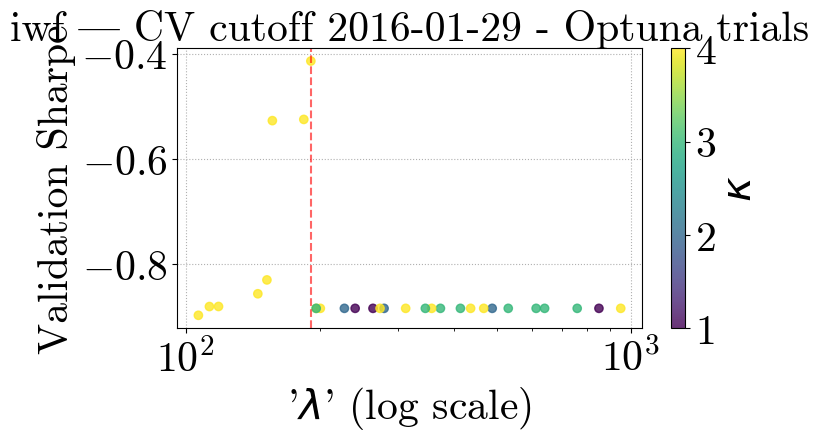

[I 2025-05-05 18:38:22,861] A new study created in memory with name: no-name-8e1c94ff-e977-45b3-a77a-af5a3b49aa16
[I 2025-05-05 18:38:24,192] Trial 0 finished with value: 1.5238071745889652 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 1.5238071745889652.
[I 2025-05-05 18:38:25,476] Trial 1 finished with value: 1.5238071745889652 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 1.5238071745889652.
[I 2025-05-05 18:38:26,332] Trial 2 finished with value: 1.523807174588965 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: 1.5238071745889652.
[I 2025-05-05 18:38:28,925] Trial 3 finished with value: 1.4527249871696846 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 0 with value: 1.5238071745889652.
[I 2025-05-05 18:38:30,280] Trial 4 finished with value: 1.5238071745889652 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 0 wi

Optuna best λ=118.5260, κ=4, Sharpe=1.5705


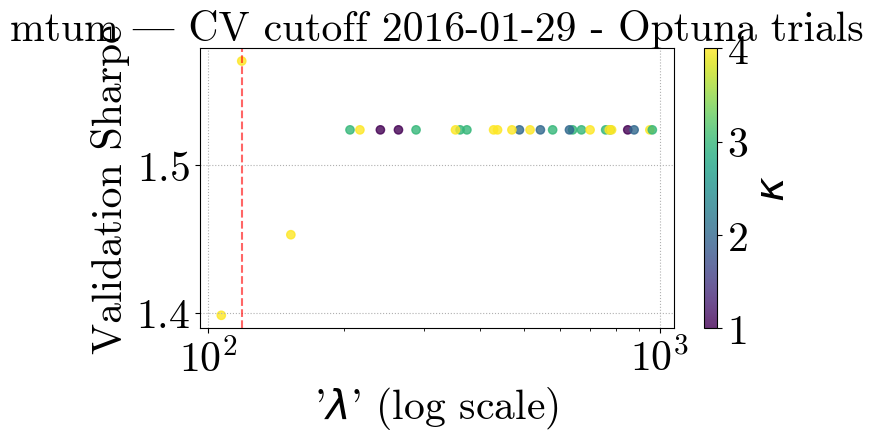

[I 2025-05-05 18:39:08,964] A new study created in memory with name: no-name-cd7bf189-48ff-4b49-af46-bb22bf01142b
[I 2025-05-05 18:39:10,205] Trial 0 finished with value: -1.3030668994684087 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -1.3030668994684087.
[I 2025-05-05 18:39:11,294] Trial 1 finished with value: -1.3030668994684087 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -1.3030668994684087.
[I 2025-05-05 18:39:12,306] Trial 2 finished with value: -0.006802118350749262 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: -0.006802118350749262.
[I 2025-05-05 18:39:14,192] Trial 3 finished with value: -0.1311605408312719 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 2 with value: -0.006802118350749262.
[I 2025-05-05 18:39:15,357] Trial 4 finished with value: -1.3030668994684087 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Be

Optuna best λ=849.1984, κ=1, Sharpe=1.2841


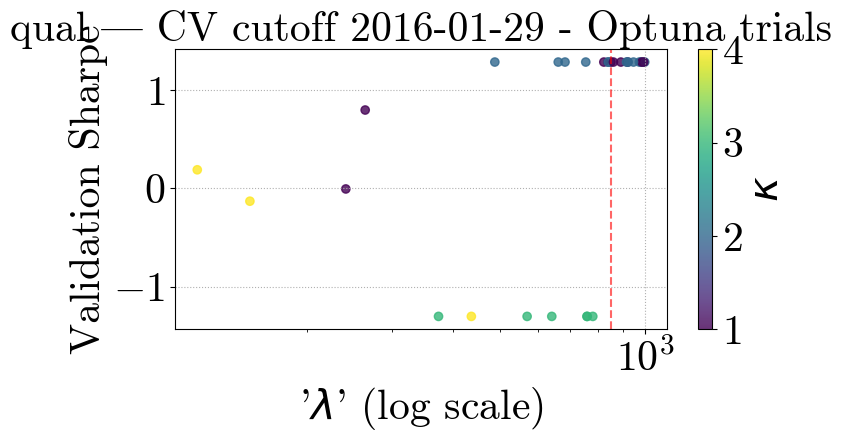

[I 2025-05-05 18:39:47,357] A new study created in memory with name: no-name-e8399f48-a54b-4fae-9dcf-8e3c4e3bf5a6
[I 2025-05-05 18:39:48,500] Trial 0 finished with value: -0.5232170393961455 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.5232170393961455.
[I 2025-05-05 18:39:50,350] Trial 1 finished with value: -0.5232170393961456 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.5232170393961455.
[I 2025-05-05 18:39:51,258] Trial 2 finished with value: -0.5232170393961457 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: -0.5232170393961455.
[I 2025-05-05 18:39:53,509] Trial 3 finished with value: -0.11883781632220988 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: -0.11883781632220988.
[I 2025-05-05 18:39:55,287] Trial 4 finished with value: -0.5232170393961456 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best i

Optuna best λ=169.6267, κ=4, Sharpe=0.0136


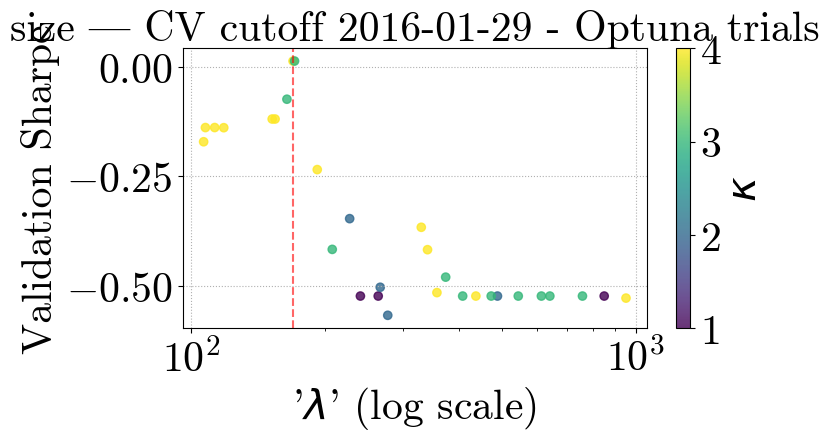

[I 2025-05-05 18:41:10,497] A new study created in memory with name: no-name-c6473efe-c29a-4eb0-b902-850653c8e96b
[I 2025-05-05 18:41:12,959] Trial 0 finished with value: -0.5977573919826558 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.5977573919826558.
[I 2025-05-05 18:41:15,468] Trial 1 finished with value: -0.6836738039592097 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.5977573919826558.
[I 2025-05-05 18:41:16,820] Trial 2 finished with value: -0.5977573919826559 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: -0.5977573919826558.
[I 2025-05-05 18:41:20,167] Trial 3 finished with value: -0.4460195048504032 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: -0.4460195048504032.
[I 2025-05-05 18:41:21,948] Trial 4 finished with value: -0.5977573919826559 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is 

Optuna best λ=106.7926, κ=4, Sharpe=0.0760


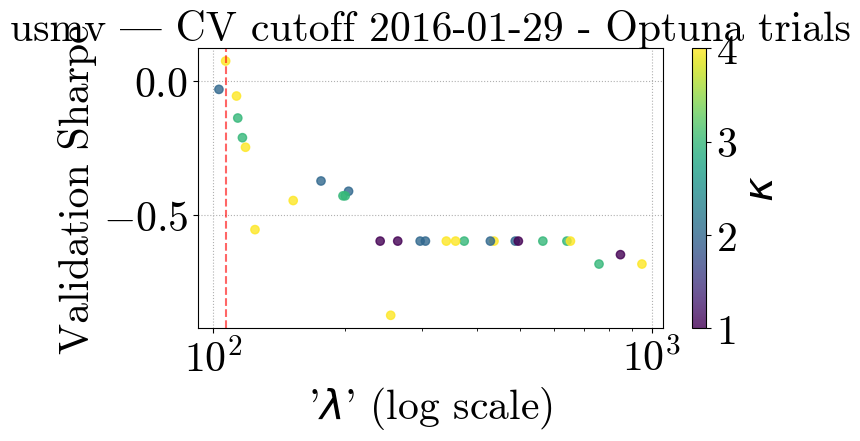

[I 2025-05-05 18:42:35,563] A new study created in memory with name: no-name-e0f0e2e4-b713-430f-b666-0aacabbff653
[I 2025-05-05 18:42:38,526] Trial 0 finished with value: 1.143911025787264 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 1.143911025787264.
[I 2025-05-05 18:42:40,143] Trial 1 finished with value: 0.27184953791463334 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 1.143911025787264.
[I 2025-05-05 18:42:41,747] Trial 2 finished with value: 1.2150636427761148 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 1.2150636427761148.
[I 2025-05-05 18:42:44,244] Trial 3 finished with value: 1.0823795672659835 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 2 with value: 1.2150636427761148.
[I 2025-05-05 18:42:46,095] Trial 4 finished with value: 0.6514012913789804 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 2 wit

Optuna best λ=184.2570, κ=2, Sharpe=1.3083


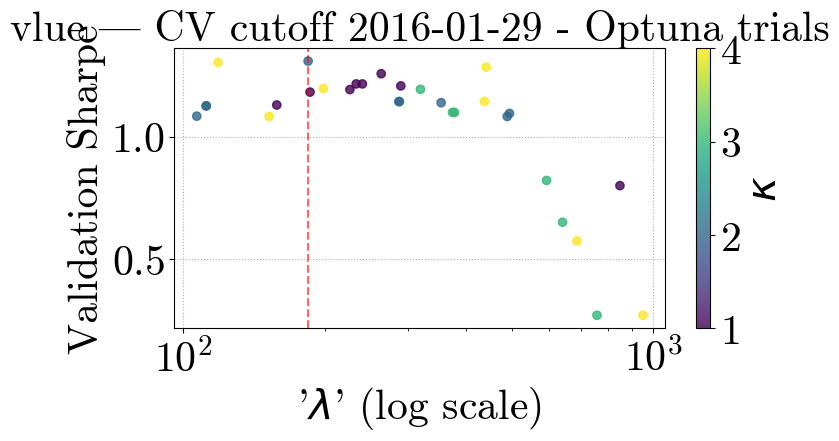

[I 2025-05-05 18:43:48,056] A new study created in memory with name: no-name-cc52d5ae-dd10-4074-8505-7243aea9c29b
[I 2025-05-05 18:43:52,200] Trial 0 finished with value: -0.730563987147049 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.730563987147049.
[I 2025-05-05 18:43:54,643] Trial 1 finished with value: -0.730563987147049 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.730563987147049.
[I 2025-05-05 18:43:56,223] Trial 2 finished with value: 0.1020678069134585 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 0.1020678069134585.
[I 2025-05-05 18:44:00,560] Trial 3 finished with value: -0.6279977681059193 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 2 with value: 0.1020678069134585.
[I 2025-05-05 18:44:04,205] Trial 4 finished with value: -0.730563987147049 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 2 

Optuna best λ=240.4168, κ=1, Sharpe=0.1021


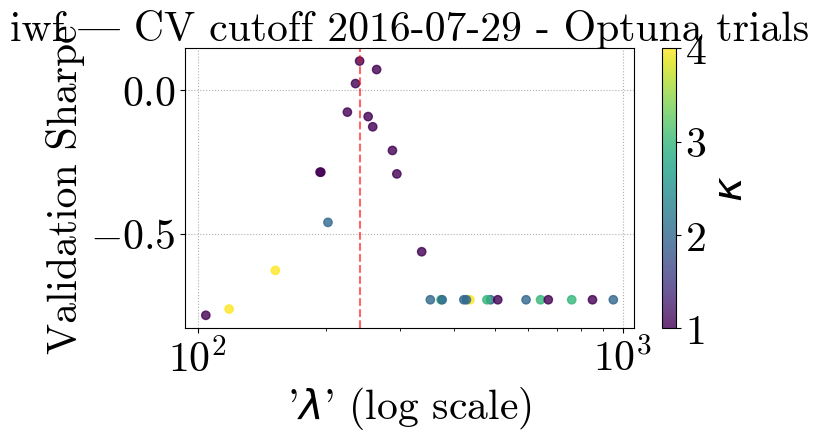

[I 2025-05-05 18:45:05,133] A new study created in memory with name: no-name-99b401b0-bcc3-4c7d-b5b9-4fc6157761c6
[I 2025-05-05 18:45:07,774] Trial 0 finished with value: 1.1761137233486407 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 1.1761137233486407.
[I 2025-05-05 18:45:12,112] Trial 1 finished with value: 1.1761137233486407 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 1.1761137233486407.
[I 2025-05-05 18:45:13,630] Trial 2 finished with value: 1.2210706451344155 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 1.2210706451344155.
[I 2025-05-05 18:45:17,458] Trial 3 finished with value: 1.2804431254290012 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 1.2804431254290012.
[I 2025-05-05 18:45:20,007] Trial 4 finished with value: 1.1761137233486407 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 3 w

Optuna best λ=133.6842, κ=4, Sharpe=1.6561


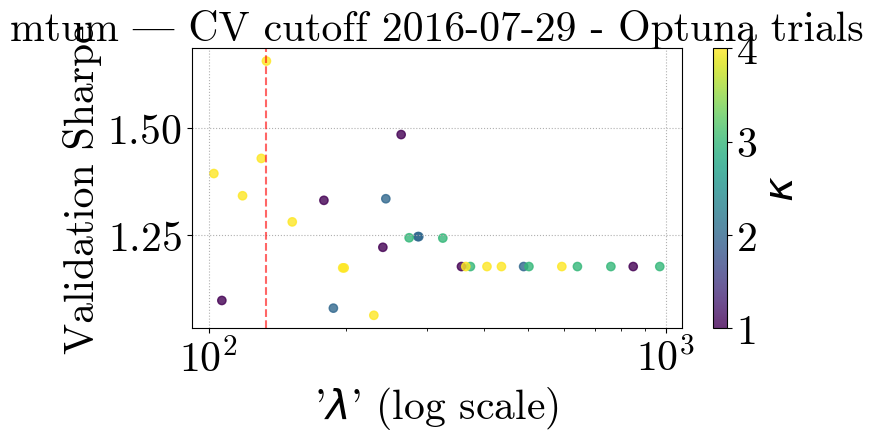

[I 2025-05-05 18:46:29,637] A new study created in memory with name: no-name-233f5d06-2711-4b48-9896-a39f8858088f
[I 2025-05-05 18:46:31,655] Trial 0 finished with value: -1.003270615272709 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -1.003270615272709.
[I 2025-05-05 18:46:33,786] Trial 1 finished with value: -1.003270615272709 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -1.003270615272709.
[I 2025-05-05 18:46:35,474] Trial 2 finished with value: 0.17845887623544476 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 0.17845887623544476.
[I 2025-05-05 18:46:38,476] Trial 3 finished with value: 0.13424411340051665 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 2 with value: 0.17845887623544476.
[I 2025-05-05 18:46:40,615] Trial 4 finished with value: -1.003270615272709 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial

Optuna best λ=849.1984, κ=1, Sharpe=0.9853


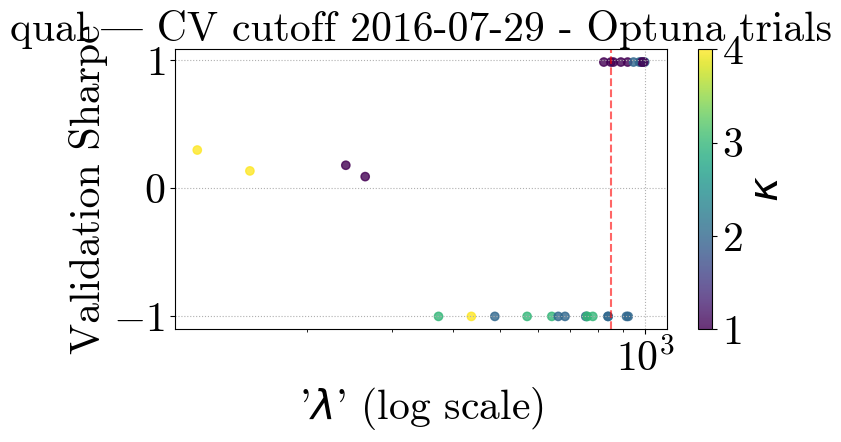

[I 2025-05-05 18:47:26,964] A new study created in memory with name: no-name-f762b2b5-07ec-44c9-b85c-0c04e00101c3
[I 2025-05-05 18:47:29,547] Trial 0 finished with value: -0.3232394253451738 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.3232394253451738.
[I 2025-05-05 18:47:32,110] Trial 1 finished with value: -0.45440626720794997 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.3232394253451738.
[I 2025-05-05 18:47:33,652] Trial 2 finished with value: -0.4544062672079501 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: -0.3232394253451738.
[I 2025-05-05 18:47:38,885] Trial 3 finished with value: 0.08793222802465989 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 0.08793222802465989.
[I 2025-05-05 18:47:42,043] Trial 4 finished with value: -0.45440626720794997 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best i

Optuna best λ=164.8054, κ=4, Sharpe=0.0922


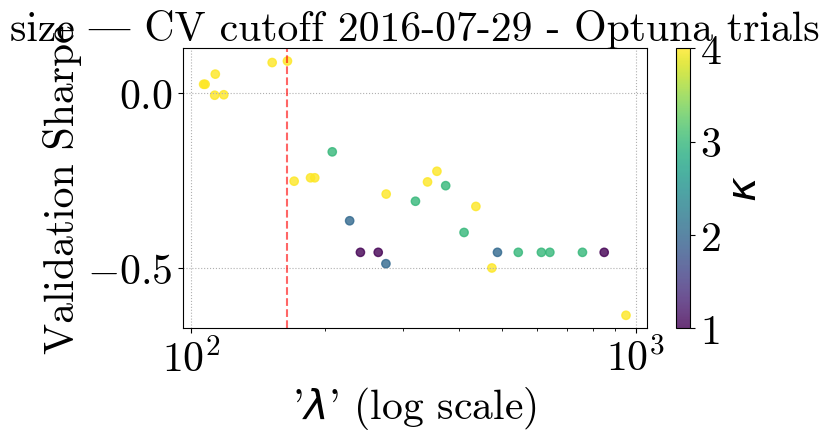

[I 2025-05-05 18:49:12,352] A new study created in memory with name: no-name-7a77b56f-7257-432c-b0f3-7399aff4a1b3
[I 2025-05-05 18:49:14,842] Trial 0 finished with value: -0.6393517814509033 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.6393517814509033.
[I 2025-05-05 18:49:17,359] Trial 1 finished with value: -0.1120086532344493 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 1 with value: -0.1120086532344493.
[I 2025-05-05 18:49:19,011] Trial 2 finished with value: -1.0725463028556492 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 1 with value: -0.1120086532344493.
[I 2025-05-05 18:49:22,760] Trial 3 finished with value: -0.2511959902807573 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 1 with value: -0.1120086532344493.
[I 2025-05-05 18:49:25,402] Trial 4 finished with value: -0.6393517814509033 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is 

Optuna best λ=118.5260, κ=4, Sharpe=0.1312


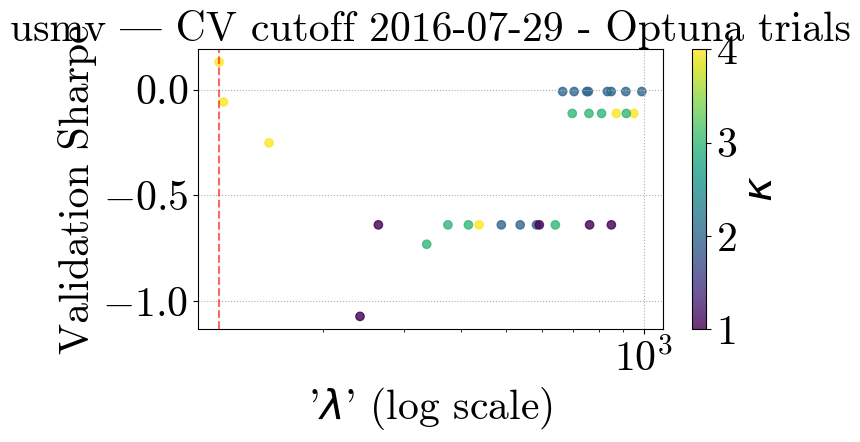

[I 2025-05-05 18:50:27,514] A new study created in memory with name: no-name-1a04bfce-01df-4721-bfdd-1b6541b286c3
[I 2025-05-05 18:50:31,064] Trial 0 finished with value: 0.2419735532868501 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 0.2419735532868501.
[I 2025-05-05 18:50:34,317] Trial 1 finished with value: -0.06443852255193727 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 0.2419735532868501.
[I 2025-05-05 18:50:36,134] Trial 2 finished with value: 0.17089456819208626 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: 0.2419735532868501.
[I 2025-05-05 18:50:39,688] Trial 3 finished with value: 0.42593709250284584 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 0.42593709250284584.
[I 2025-05-05 18:50:43,435] Trial 4 finished with value: 0.08344521121844273 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is tri

Optuna best λ=380.2108, κ=2, Sharpe=0.6591


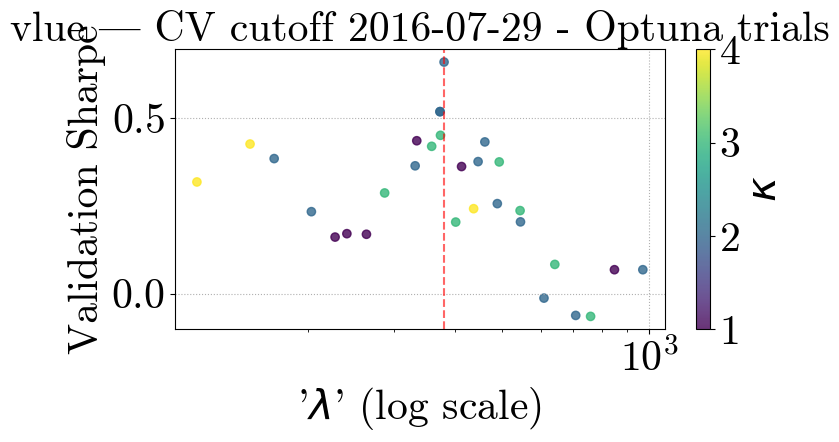

[I 2025-05-05 18:52:00,331] A new study created in memory with name: no-name-a8c434b2-5c14-4633-9eb7-d0a4c56abec3
[I 2025-05-05 18:52:04,231] Trial 0 finished with value: -0.16990143423043375 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.16990143423043375.
[I 2025-05-05 18:52:07,362] Trial 1 finished with value: -0.16990143423043375 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.16990143423043375.
[I 2025-05-05 18:52:08,667] Trial 2 finished with value: 0.9340796926487331 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 0.9340796926487331.
[I 2025-05-05 18:52:12,243] Trial 3 finished with value: -0.12320658615127834 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 2 with value: 0.9340796926487331.
[I 2025-05-05 18:52:15,134] Trial 4 finished with value: -0.16990143423043375 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best 

Optuna best λ=240.4168, κ=1, Sharpe=0.9341


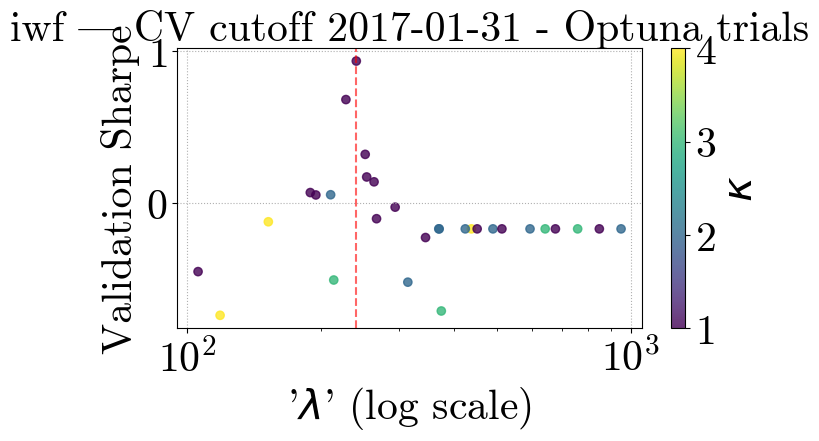

[I 2025-05-05 18:53:12,593] A new study created in memory with name: no-name-d15b70c2-6bb8-4a8c-a095-d4d2685cdbc8
[I 2025-05-05 18:53:14,623] Trial 0 finished with value: 0.728550374850522 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 0.728550374850522.
[I 2025-05-05 18:53:17,062] Trial 1 finished with value: 0.728550374850522 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 0.728550374850522.
[I 2025-05-05 18:53:18,748] Trial 2 finished with value: 0.8115811123972057 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 0.8115811123972057.
[I 2025-05-05 18:53:22,712] Trial 3 finished with value: 1.1146869711576746 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 1.1146869711576746.
[I 2025-05-05 18:53:25,331] Trial 4 finished with value: 0.728550374850522 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 3 with v

Optuna best λ=103.0962, κ=3, Sharpe=1.3030


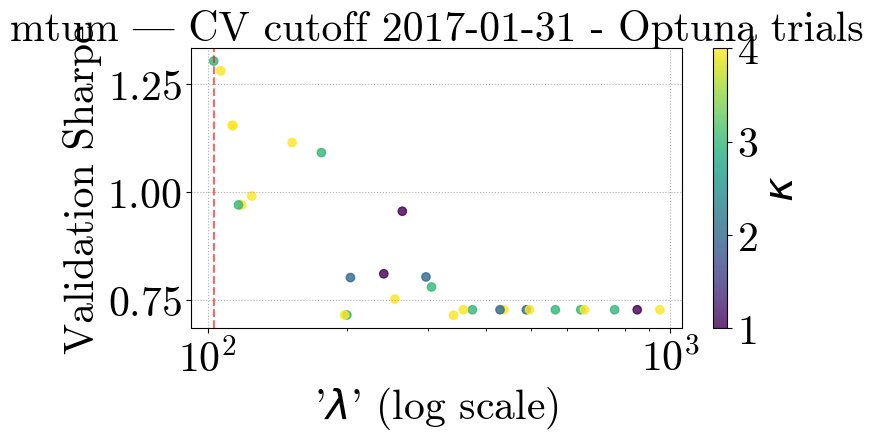

[I 2025-05-05 18:54:51,666] A new study created in memory with name: no-name-6906c8a7-56bf-478b-8f65-22c4205e88b3
[I 2025-05-05 18:54:54,691] Trial 0 finished with value: -0.6551736832562959 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.6551736832562959.
[I 2025-05-05 18:54:57,241] Trial 1 finished with value: -0.6551736832562959 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.6551736832562959.
[I 2025-05-05 18:54:59,073] Trial 2 finished with value: -0.06969218671191545 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: -0.06969218671191545.
[I 2025-05-05 18:55:02,259] Trial 3 finished with value: 0.4083962760162615 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 0.4083962760162615.
[I 2025-05-05 18:55:04,715] Trial 4 finished with value: -0.6551736832562959 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is 

Optuna best λ=849.1984, κ=1, Sharpe=0.6379


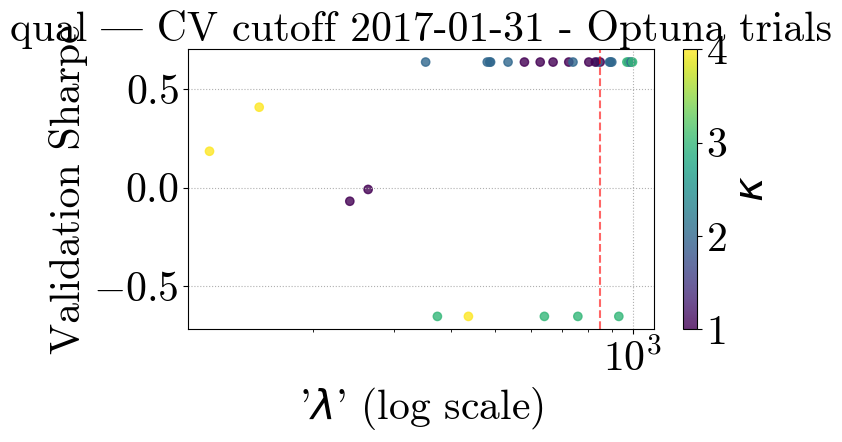

[I 2025-05-05 18:55:56,697] A new study created in memory with name: no-name-0c655954-ac41-40f2-ba80-6d2c15562144
[I 2025-05-05 18:55:58,826] Trial 0 finished with value: -0.3692993587402888 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.3692993587402888.
[I 2025-05-05 18:56:01,876] Trial 1 finished with value: -0.4772219219268638 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.3692993587402888.
[I 2025-05-05 18:56:03,550] Trial 2 finished with value: -0.4883520765484016 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: -0.3692993587402888.
[I 2025-05-05 18:56:08,984] Trial 3 finished with value: 0.1788303972951285 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 0.1788303972951285.
[I 2025-05-05 18:56:12,234] Trial 4 finished with value: -0.4772219219268638 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is tr

Optuna best λ=152.2753, κ=4, Sharpe=0.1788


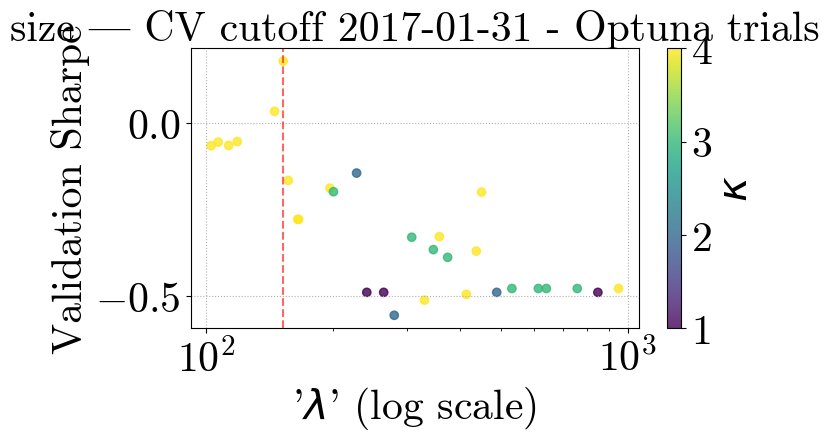

[I 2025-05-05 18:57:46,739] A new study created in memory with name: no-name-40228551-ddc1-4645-9b3e-0b2a1342d5c4
[I 2025-05-05 18:57:49,420] Trial 0 finished with value: -1.0245752344887928 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -1.0245752344887928.
[I 2025-05-05 18:57:53,502] Trial 1 finished with value: -0.1552493311625918 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 1 with value: -0.1552493311625918.
[I 2025-05-05 18:57:54,901] Trial 2 finished with value: -0.5005949917613567 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 1 with value: -0.1552493311625918.
[I 2025-05-05 18:57:59,093] Trial 3 finished with value: -0.4081718912463481 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 1 with value: -0.1552493311625918.
[I 2025-05-05 18:58:00,851] Trial 4 finished with value: -0.48188174328030237 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is

Optuna best λ=849.1984, κ=1, Sharpe=0.0987


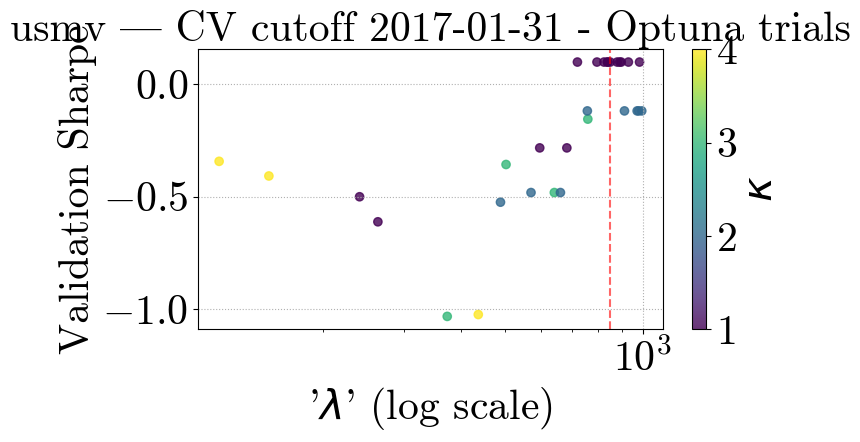

[I 2025-05-05 18:58:44,596] A new study created in memory with name: no-name-55bb1205-e499-4f39-9c67-c18a22dd1a36
[I 2025-05-05 18:58:47,658] Trial 0 finished with value: 0.7303849056895209 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 0.7303849056895209.
[I 2025-05-05 18:58:49,858] Trial 1 finished with value: 0.3973380701987932 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 0.7303849056895209.
[I 2025-05-05 18:58:51,742] Trial 2 finished with value: 0.639393666199999 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: 0.7303849056895209.
[I 2025-05-05 18:58:55,480] Trial 3 finished with value: 0.972831145425539 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 0.972831145425539.
[I 2025-05-05 18:58:57,292] Trial 4 finished with value: 0.6538784338214138 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 3 with

Optuna best λ=373.8180, κ=3, Sharpe=0.9965


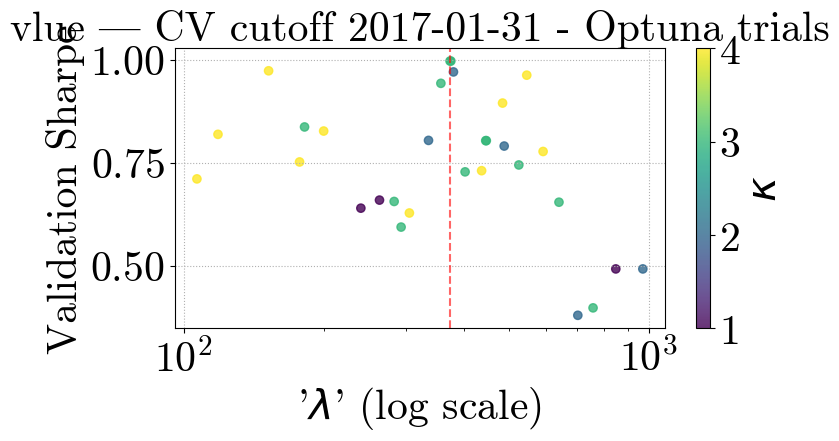

[I 2025-05-05 19:00:12,630] A new study created in memory with name: no-name-5eac8803-7b21-4058-ae7b-9ec85a7cddf5
[I 2025-05-05 19:00:16,853] Trial 0 finished with value: -0.6368910664980917 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.6368910664980917.
[I 2025-05-05 19:00:20,860] Trial 1 finished with value: -0.6368910664980917 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.6368910664980917.
[I 2025-05-05 19:00:22,612] Trial 2 finished with value: -0.12570722753864097 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: -0.12570722753864097.
[I 2025-05-05 19:00:28,222] Trial 3 finished with value: -0.5363158366519409 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 2 with value: -0.12570722753864097.
[I 2025-05-05 19:00:32,729] Trial 4 finished with value: -0.6368910664980917 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best 

Optuna best λ=285.8700, κ=1, Sharpe=0.2017


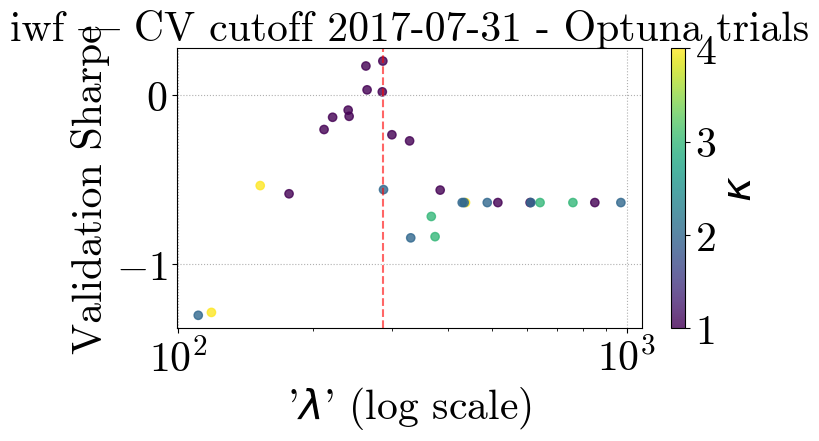

[I 2025-05-05 19:01:40,433] A new study created in memory with name: no-name-e339dc47-3f2c-45b6-8d46-1d0962fe10fa
[I 2025-05-05 19:01:42,718] Trial 0 finished with value: 1.2241679198414144 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 1.2241679198414144.
[I 2025-05-05 19:01:44,806] Trial 1 finished with value: 1.2241679198414144 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 1.2241679198414144.
[I 2025-05-05 19:01:46,409] Trial 2 finished with value: 1.3885344558276786 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 1.3885344558276786.
[I 2025-05-05 19:01:50,610] Trial 3 finished with value: 1.5217367878748222 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 1.5217367878748222.
[I 2025-05-05 19:01:53,177] Trial 4 finished with value: 1.2241679198414144 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 3 w

Optuna best λ=103.0962, κ=3, Sharpe=1.8817


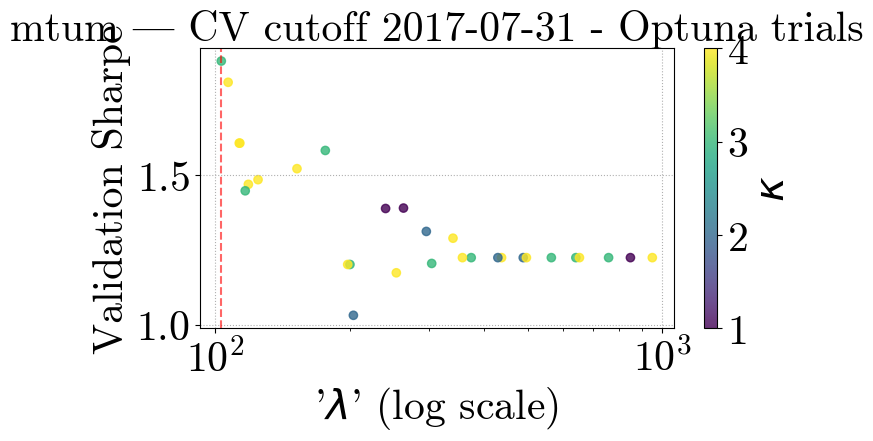

[I 2025-05-05 19:03:23,133] A new study created in memory with name: no-name-3c96ded1-6d89-4457-adf0-e7768dc479cd
[I 2025-05-05 19:03:25,977] Trial 0 finished with value: -0.7378163880806663 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.7378163880806663.
[I 2025-05-05 19:03:28,899] Trial 1 finished with value: -0.7378163880806663 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.7378163880806663.
[I 2025-05-05 19:03:30,355] Trial 2 finished with value: 0.07688474042653391 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 0.07688474042653391.
[I 2025-05-05 19:03:34,722] Trial 3 finished with value: 0.275220303723432 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 0.275220303723432.
[I 2025-05-05 19:03:37,594] Trial 4 finished with value: -0.7378163880806663 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is tria

Optuna best λ=767.4686, κ=1, Sharpe=0.7208


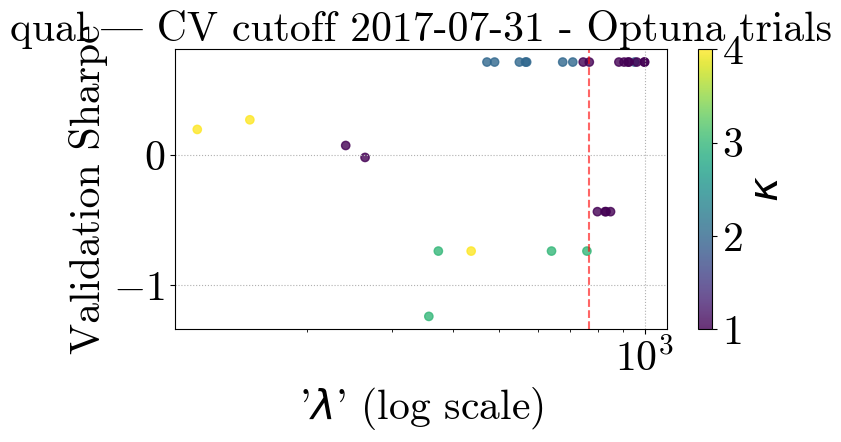

[I 2025-05-05 19:04:34,982] A new study created in memory with name: no-name-4a4c365e-7783-43db-9b71-892a8306ca6a
[I 2025-05-05 19:04:37,210] Trial 0 finished with value: -0.09044335190461486 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.09044335190461486.
[I 2025-05-05 19:04:40,096] Trial 1 finished with value: -0.31052837434579755 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.09044335190461486.
[I 2025-05-05 19:04:41,655] Trial 2 finished with value: -0.2572582555773584 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: -0.09044335190461486.
[I 2025-05-05 19:04:45,160] Trial 3 finished with value: 0.41388815234845566 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 0.41388815234845566.
[I 2025-05-05 19:04:48,093] Trial 4 finished with value: -0.31052837434579755 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Be

Optuna best λ=145.2804, κ=4, Sharpe=0.4832


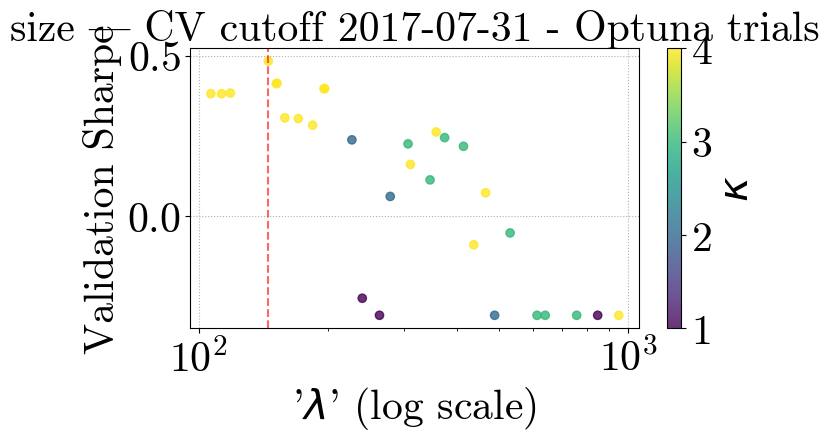

[I 2025-05-05 19:06:16,897] A new study created in memory with name: no-name-5083433c-ad46-4136-9e77-9b41292a955f
[I 2025-05-05 19:06:19,713] Trial 0 finished with value: -1.0066171367129113 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -1.0066171367129113.
[I 2025-05-05 19:06:22,513] Trial 1 finished with value: 1.1794863961524154 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 1 with value: 1.1794863961524154.
[I 2025-05-05 19:06:24,172] Trial 2 finished with value: -0.9302248741555083 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 1 with value: 1.1794863961524154.
[I 2025-05-05 19:06:27,768] Trial 3 finished with value: -0.364632676707314 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 1 with value: 1.1794863961524154.
[I 2025-05-05 19:06:29,473] Trial 4 finished with value: -0.41412923805883317 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is tria

Optuna best λ=758.7945, κ=3, Sharpe=1.1795


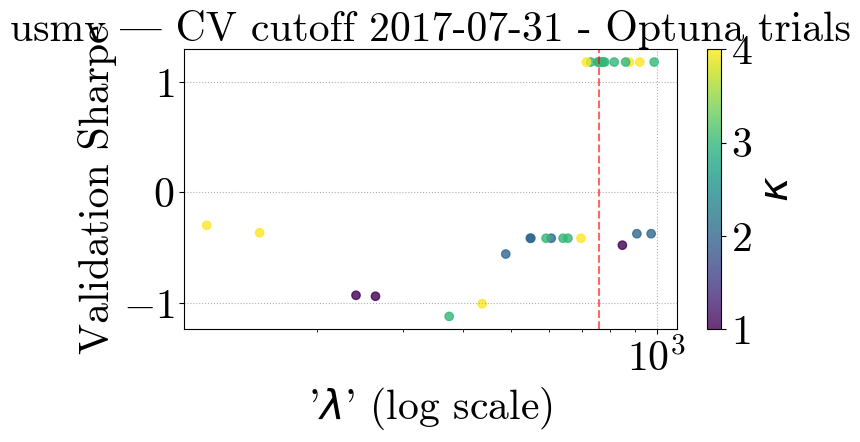

[I 2025-05-05 19:07:33,533] A new study created in memory with name: no-name-475688d6-ad95-4a59-90fd-95c0d1474824
[I 2025-05-05 19:07:35,847] Trial 0 finished with value: 0.12673869440389102 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 0.12673869440389102.
[I 2025-05-05 19:07:38,450] Trial 1 finished with value: -0.24427373900792423 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 0.12673869440389102.
[I 2025-05-05 19:07:40,391] Trial 2 finished with value: 0.12015548995087078 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: 0.12673869440389102.
[I 2025-05-05 19:07:42,849] Trial 3 finished with value: 0.3586740318438115 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 0.3586740318438115.
[I 2025-05-05 19:07:44,898] Trial 4 finished with value: 0.14272012092644779 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is t

Optuna best λ=380.2108, κ=2, Sharpe=0.4135


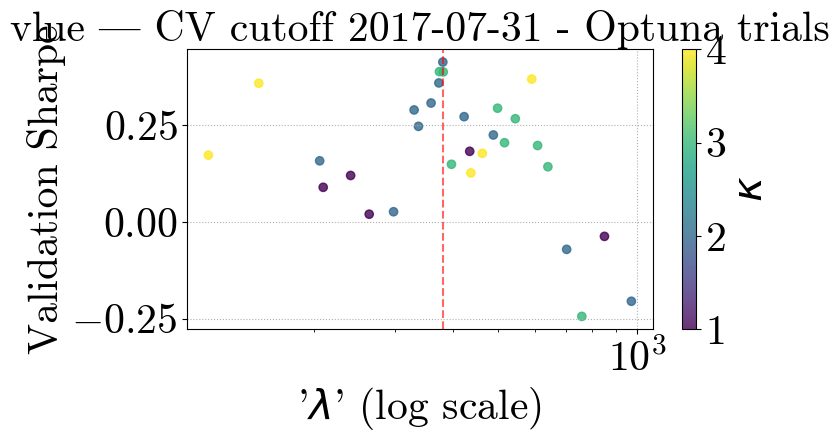

[I 2025-05-05 19:08:56,615] A new study created in memory with name: no-name-ad4a5fff-a802-46dd-8a38-0319dde9901a
[I 2025-05-05 19:08:59,787] Trial 0 finished with value: -0.6693405954750244 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.6693405954750244.
[I 2025-05-05 19:09:02,695] Trial 1 finished with value: -0.8322555030421472 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.6693405954750244.
[I 2025-05-05 19:09:04,444] Trial 2 finished with value: -0.21442580412413226 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: -0.21442580412413226.
[I 2025-05-05 19:09:08,294] Trial 3 finished with value: -0.6232159761178551 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 2 with value: -0.21442580412413226.
[I 2025-05-05 19:09:11,196] Trial 4 finished with value: -0.8322555030421472 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best 

Optuna best λ=302.2059, κ=1, Sharpe=-0.0475


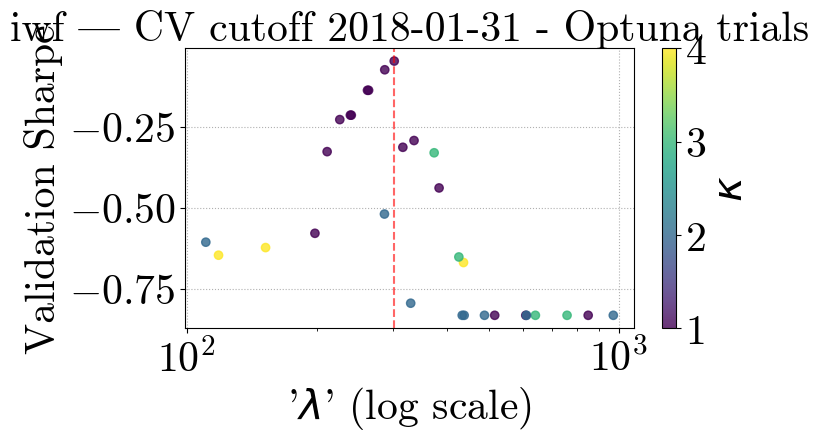

[I 2025-05-05 19:10:16,370] A new study created in memory with name: no-name-2dd31b3e-4201-4eb0-b257-14d5d0416751
[I 2025-05-05 19:10:18,725] Trial 0 finished with value: 1.3641644415664627 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 1.3641644415664627.
[I 2025-05-05 19:10:20,929] Trial 1 finished with value: 1.3641644415664627 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 1.3641644415664627.
[I 2025-05-05 19:10:22,767] Trial 2 finished with value: 1.552345998177922 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 1.552345998177922.
[I 2025-05-05 19:10:27,594] Trial 3 finished with value: 1.6389326498462027 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 1.6389326498462027.
[I 2025-05-05 19:10:29,966] Trial 4 finished with value: 1.3641644415664627 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 3 wit

Optuna best λ=131.3723, κ=4, Sharpe=2.0002


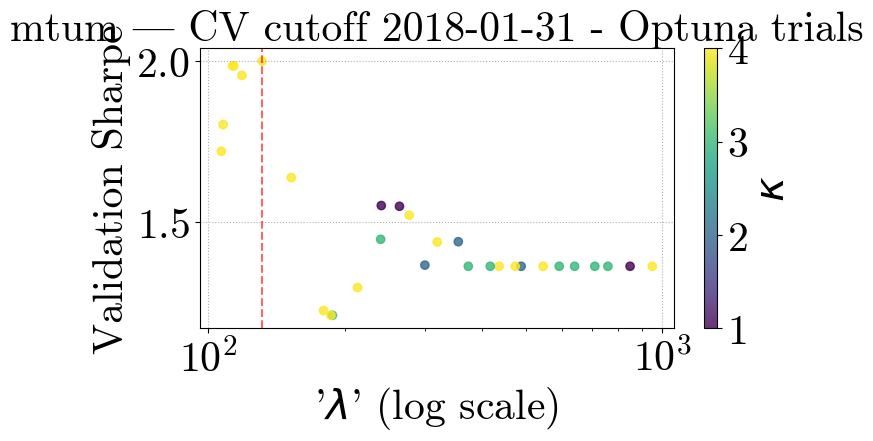

[I 2025-05-05 19:11:52,347] A new study created in memory with name: no-name-1f9bba59-0a93-4295-96c5-b4d11c606889
[I 2025-05-05 19:11:55,384] Trial 0 finished with value: 0.6509218552307324 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 0.6509218552307324.
[I 2025-05-05 19:11:58,116] Trial 1 finished with value: 0.6509218552307324 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 0.6509218552307324.
[I 2025-05-05 19:11:59,761] Trial 2 finished with value: -0.08383591816534003 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: 0.6509218552307324.
[I 2025-05-05 19:12:05,180] Trial 3 finished with value: 0.40780647379408047 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 0 with value: 0.6509218552307324.
[I 2025-05-05 19:12:07,700] Trial 4 finished with value: 0.6509218552307324 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 

Optuna best λ=316.1123, κ=2, Sharpe=0.7966


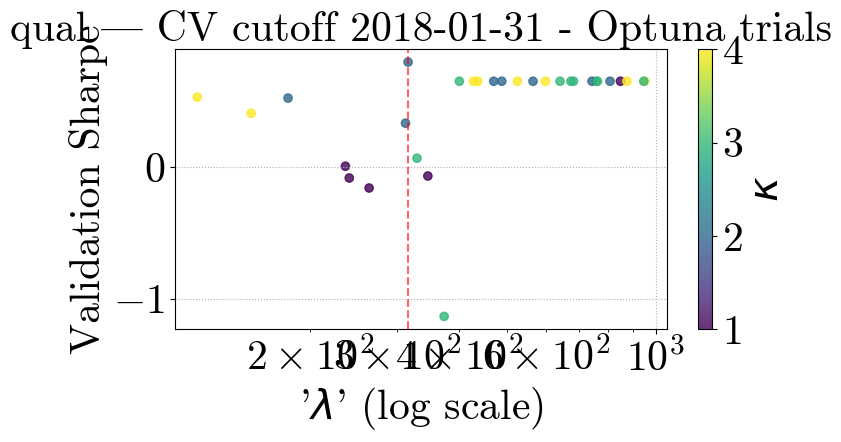

[I 2025-05-05 19:13:32,374] A new study created in memory with name: no-name-b60110f8-07f7-4751-bdde-d49f6f349077
[I 2025-05-05 19:13:34,667] Trial 0 finished with value: -0.10678423004746013 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.10678423004746013.
[I 2025-05-05 19:13:36,911] Trial 1 finished with value: -0.07417517673596982 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 1 with value: -0.07417517673596982.
[I 2025-05-05 19:13:38,249] Trial 2 finished with value: -0.10678423004746007 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 1 with value: -0.07417517673596982.
[I 2025-05-05 19:13:41,651] Trial 3 finished with value: -0.017427825162839777 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: -0.017427825162839777.
[I 2025-05-05 19:13:43,794] Trial 4 finished with value: -0.10678423004746013 and parameters: {'lambda': 641.0035105688879, 'kappa': 3

Optuna best λ=980.1965, κ=2, Sharpe=0.1389


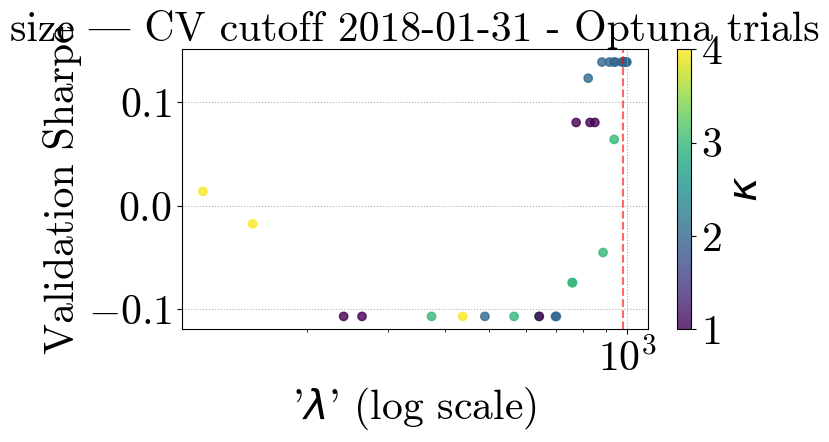

[I 2025-05-05 19:14:34,377] A new study created in memory with name: no-name-5930050c-67bd-4fb6-bfdf-c1ec16175e07
[I 2025-05-05 19:14:36,971] Trial 0 finished with value: -0.7411738451095233 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.7411738451095233.
[I 2025-05-05 19:14:40,073] Trial 1 finished with value: 0.08246829190799912 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 1 with value: 0.08246829190799912.
[I 2025-05-05 19:14:41,739] Trial 2 finished with value: -0.5726241115293473 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 1 with value: 0.08246829190799912.
[I 2025-05-05 19:14:46,066] Trial 3 finished with value: -0.055560584801232694 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 1 with value: 0.08246829190799912.
[I 2025-05-05 19:14:49,103] Trial 4 finished with value: 0.08246829190799912 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best i

Optuna best λ=758.7945, κ=3, Sharpe=0.0825


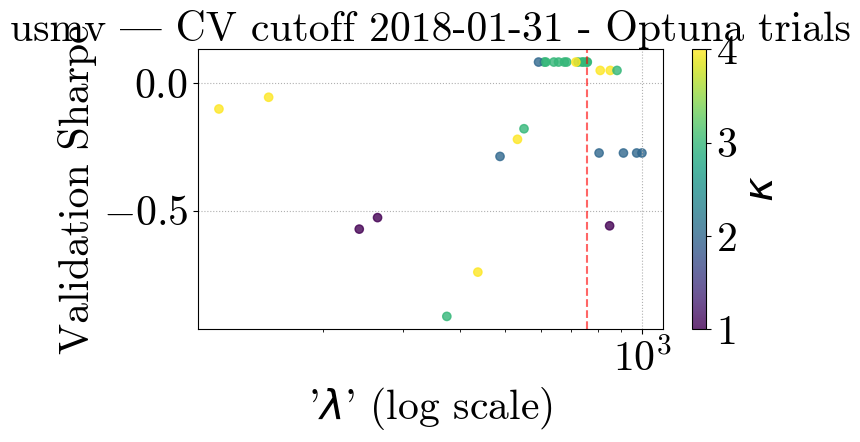

[I 2025-05-05 19:16:01,323] A new study created in memory with name: no-name-bd71c85b-df68-4e65-945b-826079c1b19d
[I 2025-05-05 19:16:03,247] Trial 0 finished with value: 0.4784661942017253 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 0.4784661942017253.
[I 2025-05-05 19:16:05,297] Trial 1 finished with value: 0.45976176337218283 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 0.4784661942017253.
[I 2025-05-05 19:16:07,358] Trial 2 finished with value: 0.3152603304582055 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: 0.4784661942017253.
[I 2025-05-05 19:16:10,439] Trial 3 finished with value: 0.5961076545402622 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 0.5961076545402622.
[I 2025-05-05 19:16:12,424] Trial 4 finished with value: 0.44250435652599085 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 3

Optuna best λ=849.1984, κ=1, Sharpe=0.6518


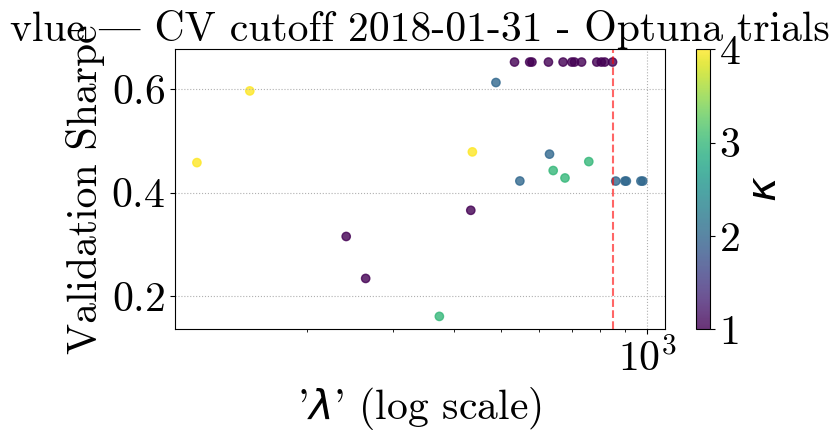

[I 2025-05-05 19:17:03,371] A new study created in memory with name: no-name-c866ef22-a639-4c17-b0d7-b1d8ba4afe2a
[I 2025-05-05 19:17:06,506] Trial 0 finished with value: -0.3987306326986233 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.3987306326986233.
[I 2025-05-05 19:17:09,570] Trial 1 finished with value: -0.3987306326986233 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.3987306326986233.
[I 2025-05-05 19:17:11,380] Trial 2 finished with value: -0.15338039132184603 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: -0.15338039132184603.
[I 2025-05-05 19:17:14,321] Trial 3 finished with value: -0.12594490778692757 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: -0.12594490778692757.
[I 2025-05-05 19:17:17,159] Trial 4 finished with value: -0.3987306326986233 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best

Optuna best λ=970.7828, κ=2, Sharpe=0.5835


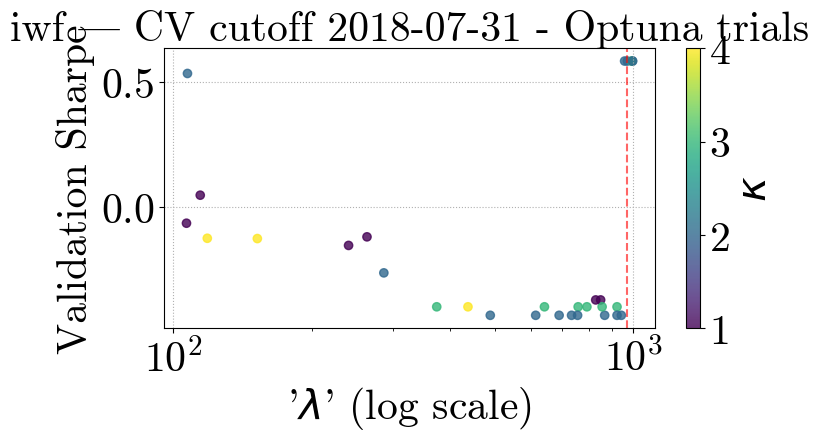

[I 2025-05-05 19:18:10,327] A new study created in memory with name: no-name-127a90c9-ef51-4385-9a99-cfcbc18515da
[I 2025-05-05 19:18:12,620] Trial 0 finished with value: 1.0313840716670115 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 1.0313840716670115.
[I 2025-05-05 19:18:14,796] Trial 1 finished with value: 1.0313840716670115 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 1.0313840716670115.
[I 2025-05-05 19:18:16,689] Trial 2 finished with value: 1.143878188941943 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 1.143878188941943.
[I 2025-05-05 19:18:21,059] Trial 3 finished with value: 1.3582410834654433 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 3 with value: 1.3582410834654433.
[I 2025-05-05 19:18:23,249] Trial 4 finished with value: 1.0313840716670115 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 3 wit

Optuna best λ=110.6778, κ=4, Sharpe=1.4377


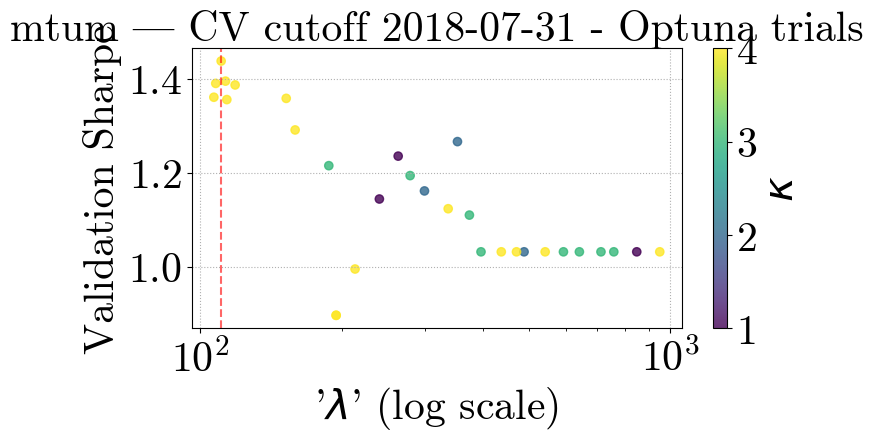

[I 2025-05-05 19:19:40,017] A new study created in memory with name: no-name-78e18ea8-4552-4523-9486-1593be926868
[I 2025-05-05 19:19:42,166] Trial 0 finished with value: 0.45715484506004617 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 0.45715484506004617.
[I 2025-05-05 19:19:44,036] Trial 1 finished with value: 0.45715484506004617 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 0.45715484506004617.
[I 2025-05-05 19:19:45,596] Trial 2 finished with value: 0.469961643778492 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 0.469961643778492.
[I 2025-05-05 19:19:49,706] Trial 3 finished with value: 0.3929652279523663 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 2 with value: 0.469961643778492.
[I 2025-05-05 19:19:51,661] Trial 4 finished with value: 0.45715484506004617 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 2

Optuna best λ=849.1984, κ=1, Sharpe=0.7814


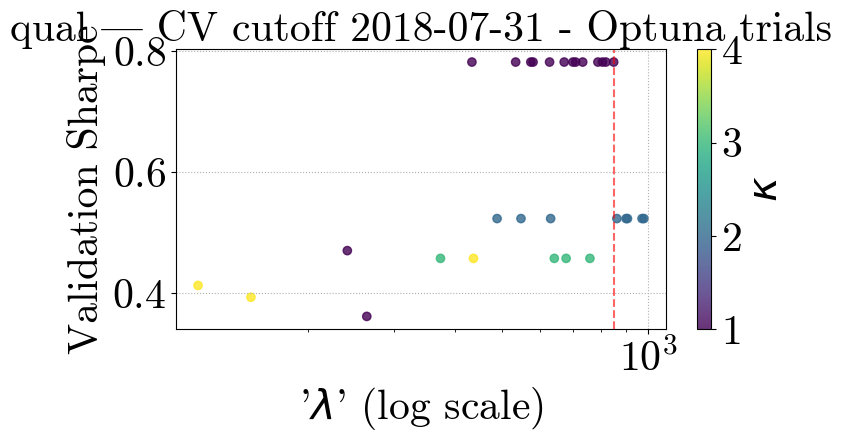

[I 2025-05-05 19:20:42,941] A new study created in memory with name: no-name-f4ebb335-9f3a-4933-963a-c5a7f8e1b40b
[I 2025-05-05 19:20:44,953] Trial 0 finished with value: -0.358827108732753 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.358827108732753.
[I 2025-05-05 19:20:46,699] Trial 1 finished with value: -0.358827108732753 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.358827108732753.
[I 2025-05-05 19:20:48,343] Trial 2 finished with value: 0.4052503942275845 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 0.4052503942275845.
[I 2025-05-05 19:20:51,631] Trial 3 finished with value: 0.053119302068857 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 2 with value: 0.4052503942275845.
[I 2025-05-05 19:20:53,673] Trial 4 finished with value: -0.358827108732753 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 2 wi

Optuna best λ=240.4168, κ=1, Sharpe=0.4053


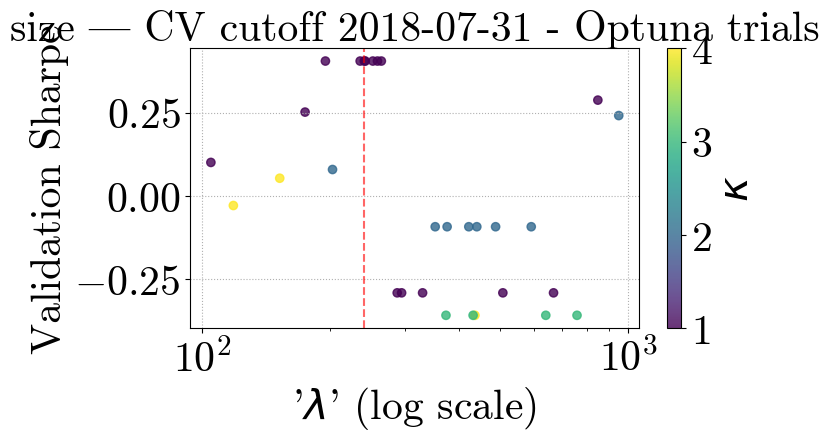

[I 2025-05-05 19:21:46,490] A new study created in memory with name: no-name-a22ba60f-0146-4ed4-9080-3b888a0c4f13
[I 2025-05-05 19:21:49,343] Trial 0 finished with value: -0.5081636089050469 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.5081636089050469.
[I 2025-05-05 19:21:52,317] Trial 1 finished with value: -0.02857046241574455 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 1 with value: -0.02857046241574455.
[I 2025-05-05 19:21:53,793] Trial 2 finished with value: -0.6287354421900969 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 1 with value: -0.02857046241574455.
[I 2025-05-05 19:21:57,465] Trial 3 finished with value: -0.41231790073152375 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 1 with value: -0.02857046241574455.
[I 2025-05-05 19:22:00,193] Trial 4 finished with value: -0.02857046241574455 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Be

Optuna best λ=849.1984, κ=1, Sharpe=-0.0073


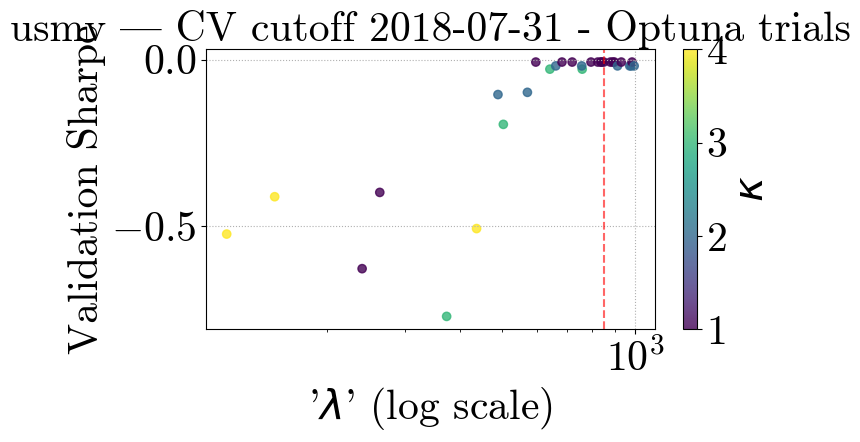

[I 2025-05-05 19:22:47,565] A new study created in memory with name: no-name-8da07af4-21bb-41d3-87f0-87817286d3ce
[I 2025-05-05 19:22:50,302] Trial 0 finished with value: 0.7596830718451636 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 0.7596830718451636.
[I 2025-05-05 19:22:52,446] Trial 1 finished with value: 0.7173330969959526 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 0.7596830718451636.
[I 2025-05-05 19:22:54,367] Trial 2 finished with value: 0.5023530398206512 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: 0.7596830718451636.
[I 2025-05-05 19:22:56,938] Trial 3 finished with value: 0.6460058771670192 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 0 with value: 0.7596830718451636.
[I 2025-05-05 19:22:58,754] Trial 4 finished with value: 0.6636683713146954 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 0 w

Optuna best λ=461.4918, κ=2, Sharpe=0.8049


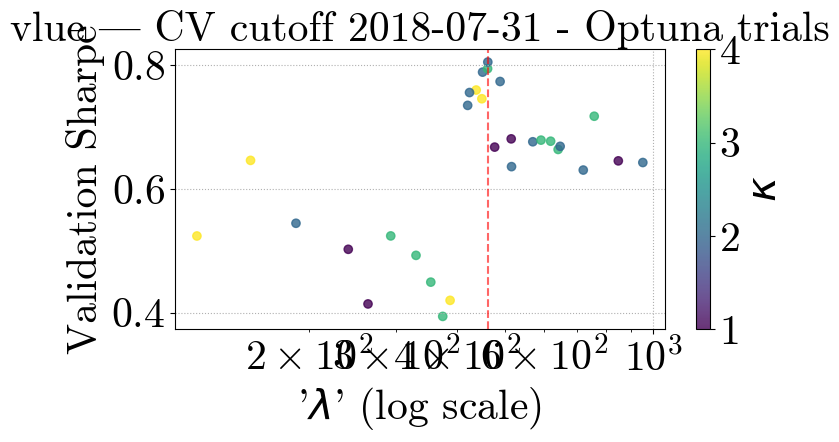

[I 2025-05-05 19:24:08,221] A new study created in memory with name: no-name-273fafba-b27e-4571-bf81-163acd763574
[I 2025-05-05 19:24:10,519] Trial 0 finished with value: 0.19528829785995497 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 0.19528829785995497.
[I 2025-05-05 19:24:12,458] Trial 1 finished with value: 0.133005772751673 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: 0.19528829785995497.
[I 2025-05-05 19:24:14,188] Trial 2 finished with value: -0.012288205438173326 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 0 with value: 0.19528829785995497.
[I 2025-05-05 19:24:17,588] Trial 3 finished with value: 0.07277461216719085 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 0 with value: 0.19528829785995497.
[I 2025-05-05 19:24:19,518] Trial 4 finished with value: -0.10710713691842388 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is

Optuna best λ=837.2633, κ=2, Sharpe=0.4712


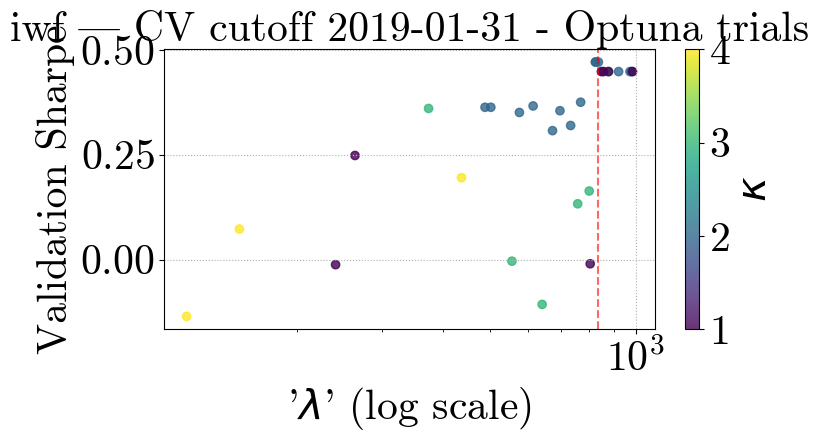

[I 2025-05-05 19:25:11,965] A new study created in memory with name: no-name-3b5e8926-7fff-420c-89f2-b5f67af3453d
[I 2025-05-05 19:25:14,082] Trial 0 finished with value: 0.6302420478156143 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: 0.6302420478156143.
[I 2025-05-05 19:25:16,134] Trial 1 finished with value: 0.9361815235097943 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 1 with value: 0.9361815235097943.
[I 2025-05-05 19:25:17,916] Trial 2 finished with value: 0.9987556376077141 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 0.9987556376077141.
[I 2025-05-05 19:25:22,271] Trial 3 finished with value: 0.7939202808855574 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 2 with value: 0.9987556376077141.
[I 2025-05-05 19:25:24,352] Trial 4 finished with value: 0.9432081513279954 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. Best is trial 2 w

Optuna best λ=118.5260, κ=4, Sharpe=1.0324


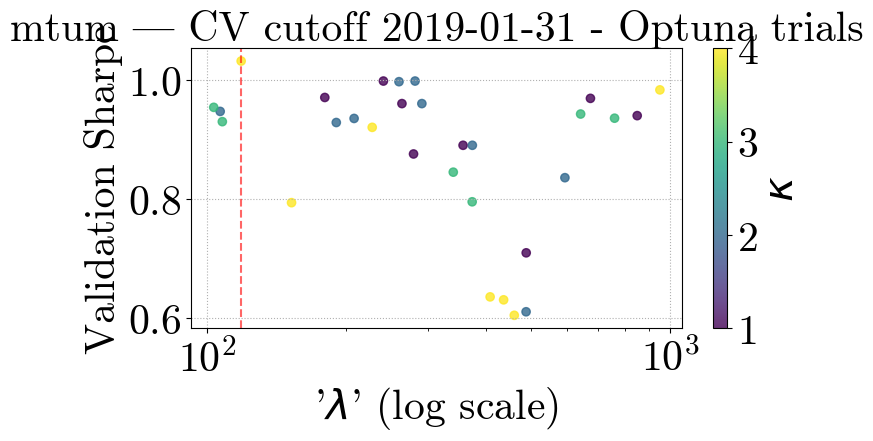

[I 2025-05-05 19:26:32,784] A new study created in memory with name: no-name-915be474-9e22-4fe8-99d2-401f7e431cb0
[I 2025-05-05 19:26:34,896] Trial 0 finished with value: -0.026504308711194774 and parameters: {'lambda': 437.0861069626262, 'kappa': 4}. Best is trial 0 with value: -0.026504308711194774.
[I 2025-05-05 19:26:37,700] Trial 1 finished with value: -0.09028027063562453 and parameters: {'lambda': 758.7945476302646, 'kappa': 3}. Best is trial 0 with value: -0.026504308711194774.
[I 2025-05-05 19:26:39,251] Trial 2 finished with value: 0.01294943057163736 and parameters: {'lambda': 240.41677639819287, 'kappa': 1}. Best is trial 2 with value: 0.01294943057163736.
[I 2025-05-05 19:26:42,824] Trial 3 finished with value: -0.04322340816186568 and parameters: {'lambda': 152.27525095137952, 'kappa': 4}. Best is trial 2 with value: 0.01294943057163736.
[I 2025-05-05 19:26:44,982] Trial 4 finished with value: 0.02181779373462128 and parameters: {'lambda': 641.0035105688879, 'kappa': 3}. 

In [ ]:
# -------------------------  QUICK STAND‑ALONE RUN  ----------------------- #
# ---- user‑specific setup (exactly as in your original script) -------- #

# Paths & tickers -----------------------------------------------------------------------
TEST_START       = "2016-01-01"
RECROSS_VAL_FREQ = "6ME"          # six‑month‑end


script_dir = os.getcwd()
base_dir   = os.path.abspath(os.path.join(script_dir, "..", ".."))
data_dir   = os.path.join(base_dir, "data_new")

factor_file = os.path.join(data_dir, "1estimation_index_returns.csv")
market_file = os.path.join(data_dir, "1macro_data.csv")
etf_file    = os.path.join(data_dir, "2trading_etf_returns_aligned.csv")

factors = ["iwf", "mtum", "qual", "size", "usmv", "vlue"]   

# lambda_values = np.linspace(30, 400, 5)
# # kappa grid can depend on feature count; a simple fixed grid is fine
# kappa_values  = np.array([2.0, 3.0, 4.0]) # kappa = trial.suggest_int("kappa", 1, np.sqrt(17))

# ------- load full data into factor_data_dict here -------------------- #
# (use your existing MergedDataLoader logic)
factor_data_dict = {}
for fac in factors:
    data = MergedDataLoader(
                factor_file=factor_file,
                market_file=market_file,
                ver="v2",
                factor_col=fac).load()

    common_idx = (data.X.index
                    .intersection(data.ret_ser.index)
                    .intersection(data.market_ser.index))

    factor_data_dict[fac] = {
        "X":       data.X.loc[common_idx],
        "fac_ret": data.ret_ser.loc[common_idx],
        "mkt_ret": data.market_ser.loc[common_idx],
    }


master_index = factor_data_dict[factors[0]]["X"].index.sort_values()
test_index   = master_index[master_index >= TEST_START]

recross_val_boundaries = (
    test_index.to_series()
    .resample(RECROSS_VAL_FREQ)
    .last()
    .dropna()                     # Series of Timestamp objects
)
# ----------------------------------------------------------------------

cv_table = run_cv(
    factors,
    factor_data_dict,
    cv_dates=recross_val_boundaries,
    initial_train_start="2002-05-31"
)

print("Saved tuned parameters to cv_params.parquet")
print(cv_table.head())

In [ ]:
# # 1) Cast kappa to float
# cv_table["best_kappa"] = cv_table["best_kappa"].astype(float)

# # 2) (Optional) verify
# print(cv_table.dtypes)

# # 3) Save out
# cv_table.to_parquet("cv_params_bayes_v2.parquet", index=False) # v2 is the one searching from 0.1 to 1000


date           datetime64[ns]
factor                 object
best_lambda           float64
best_kappa            float64
dtype: object


In [5]:
with open("cell_output.txt", "w") as f:
    for r in records:  # or whatever your output list is
        f.write(str(r) + "\n")


NameError: name 'records' is not defined